In [ ]:
import cv2
import numpy as np
import os
import shutil

## apply watershed and convert to hsv
path = "jpgData"
dirs = [os.path.join(path,dir) for dir in os.listdir(path)]
classes = os.listdir(path)
newPath = 'close_seg'

for c in classes:
    classPath = os.path.join(newPath,c)
    if os.path.exists(classPath): shutil.rmtree(classPath); os.mkdir(classPath)
    else: os.mkdir(classPath)

oldImages = []
for dir in dirs:
    for image in os.listdir(dir):
        oldImages.append(os.path.join(dir,image))

for image in oldImages:
    # Load image
    img = cv2.imread(image)#[100:300, 100:300, :]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    orig_img = img.copy()

    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    # Threshold Processing
    ret, bin_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Noise removal
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel, iterations=7)
    bin_img = cv2.dilate(bin_img, kernel, iterations=5)
    # Distance transform
    dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
    # Foreground area
    ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
    sure_fg = sure_fg.astype(np.uint8)

    new_image_size=128
    # Apply the mask to the original image to extract the region
    region = cv2.bitwise_and(orig_img, orig_img, mask=sure_fg)
    # Find the bounding box coordinates (non-zero pixels)
    non_zero_coords = np.argwhere(region > 0)
    min_y, min_x, _ = non_zero_coords.min(axis=0)
    max_y, max_x, _ = non_zero_coords.max(axis=0)
    # Crop the region to include only non-zero pixels
    cropped_region = region[min_y:max_y + 1, min_x:max_x + 1]
    cropped_region = cv2.resize(cropped_region, (new_image_size, new_image_size))

    rgb_planes = cv2.split(cropped_region)
    result_planes = []
    # Create a CLAHE object.
    clahe = cv2.createCLAHE(tileGridSize=(3,3),clipLimit=10)
    for plane in rgb_planes:
        processed_image = cv2.medianBlur(plane, 7)
        processed_image = clahe.apply(processed_image) 
        result_planes.append(processed_image)
    result = cv2.merge(result_planes)

    HSV = cv2.cvtColor(result,cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(HSV)
    V *= 0
    HS = cv2.merge([H,S,V])

    cv2.imwrite(image.replace(path,newPath,1),HS)

In [ ]:
import os
import numpy as np
import csv

preprocessingPath="close_seg"
path = "data"
classes = os.listdir(preprocessingPath)
trainPath = "df//train_df.csv"
valPath = "df//val_df.csv"
train = 0.80 # ;val = 1. - train

np.random.seed(26)

## Setting file headers
header = ["path","pH"]
trainFile= open (trainPath, "w")
trainWriter = csv.writer(trainFile)
trainWriter.writerow(header)
valFile=open (valPath, "w")
valWriter = csv.writer(valFile)
valWriter.writerow(header)

## SEPARATING TO TRAIN AND VALIDATION SETS
for c in classes:
    classPath = os.path.join(preprocessingPath,c)
    images = np.array(os.listdir(classPath))
    np.random.shuffle(images)
    numImages = len(images)
    for n,image in enumerate(images):
        imagePath = os.path.join(classPath,image)
        if n < round(160*train): 
            trainWriter.writerow([imagePath,int(c)])
        else:
            valWriter.writerow([imagePath,int(c)])
        if n >= 160: break
trainFile.close()
valFile.close()

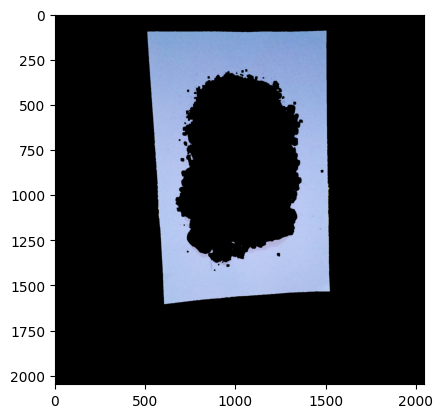

In [72]:
# ## CODE EXTRACTING WHITE FROM BACKGROUND

# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# root = "../assets/raw"
# images = os.listdir(root)
# path = os.path.join(root, images[0])
# image = cv2.imread(path)
# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# # mask = rgb_image[:,:,2]>100
# kernel = np.ones((3, 3), np.uint8)
# binr = cv2.threshold(rgb_image[:,:,2], 120, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1] 
# opening = cv2.erode(binr, kernel, iterations=3)
# # kernel = np.ones((3, 3), np.uint8)
# # closing = cv2.morphologyEx(binr, cv2.MORPH_CLOSE, kernel, iterations=5) 
# channels = cv2.split(rgb_image)
# output = []
# for channel in channels:
#     overlayed_channel = np.bitwise_and(channel, opening)
#     output.append(overlayed_channel)
# output = cv2.merge(output)
# # output = np.bitwise_and(rgb_image,closing)

# plt.imshow(output, cmap="gray")
# plt.show()

In [76]:
def center_crop(img, dim):
  """Returns center cropped image

  Args:
  img: image to be center cropped
  dim: dimensions (width, height) to be cropped from center
  """
  center = img.shape
  h = img.shape[0]
  w = img.shape[1]
  x = center[1]/2 - dim/2
  y = center[0]/2 - dim/2

  crop_img = img[int(y):int(y+h), int(x):int(x+w)]
  return crop_img

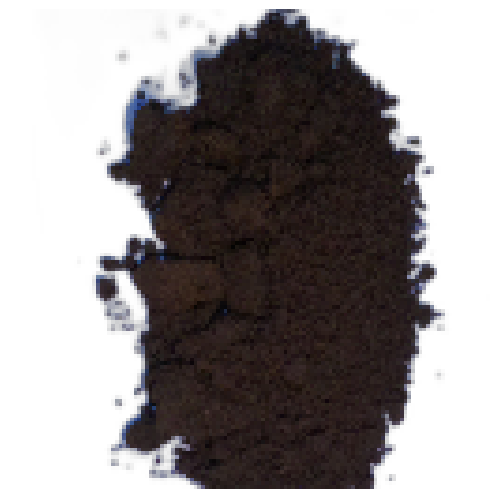

In [137]:
'''
    CODE FOR EXTRACTING SOIL FROM BACKGROUND IMAGE USING 
    IMAGE PROCESSING TECHNIQUES
'''

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove

root = "../assets/raw"
images = [x for x in os.listdir(root) if x.split('.')[1]=='jpg']
path = os.path.join(root, images[1])
output_path = (os.path.join(root,'sample.png'))

image = cv2.imread(path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Thresholding to get the white region
binr = cv2.threshold(rgb_image[:, :, 2], 250, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Eroding to remove noise and small white regions
kernel = np.ones((5, 5), np.uint8)
opening = cv2.erode(binr, kernel, iterations=5)

# Finding contours in the white region
contours, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filling the contours with white color
filled_image = np.zeros_like(opening)
cv2.drawContours(filled_image, contours, -1, 255, thickness=cv2.FILLED)

# Bitwise AND with the original image to keep the soil and white paper
output = cv2.bitwise_and(rgb_image, rgb_image, mask=filled_image)

# Remove remaining white background
output = remove(output)

# Find the bounding box coordinates (non-zero pixels)
non_zero_coords = np.argwhere(output > 0)
min_y, min_x, _ = non_zero_coords.min(axis=0)
max_y, max_x, _ = non_zero_coords.max(axis=0)

# Crop the region to include only non-zero pixels
cropped_region = output[min_y:max_y + 1, min_x:max_x + 1]
shape = cropped_region.shape[0]
if cropped_region.shape[0] > cropped_region.shape[1]: shape = cropped_region.shape[1]

cropped_region = center_crop(cropped_region, shape)

# Resize the output
final_output = cv2.resize(cropped_region, (128,128))

plt.imshow(final_output)
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Save the plot
plt.savefig(output_path, bbox_inches='tight', pad_inches=0, transparent=True)

# Show the plot
plt.show()


In [136]:
images

['artificial_agro_18.jpg', 'artificial_agro_20.jpg', 'artificial_agro_5.jpg']